# Animate trajectory

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import mpl_toolkits.mplot3d.axes3d as p3
import os

from mog_model import GaussianMixtureModel

colors = ['C0', 'C1', 'C2', 'C4', 'C5', 'C6']

In [2]:
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring

In [3]:
def gen(n):
    phi = 0
    while phi < 2 * np.pi:
        yield np.array([np.cos(phi), np.sin(phi), phi])
        phi += 2 * np.pi / n

In [4]:
def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

In [5]:
def rand_traj(trajectories):
    num_trajectories = trajectories.shape[1]
    return np.random.randint(num_trajectories)

### Define Params

In [39]:
x_dim = 2
num_distributions = 8
sigma = 0.02
radius = 2

covs, distribution = gen_ring(r=radius, 
                              var=sigma, 
                              nb_mixtures=num_distributions)
means = distribution.mus

params = {                          # default parameter values
    'x_dim': x_dim,
    'num_distributions': num_distributions,
    'means': means,
    'sigma': 0.01,
    'small_pi': 2E-16,
    'scale': 0.1,
    'num_samples': 200,
    'lr_init': 1e-3,
    'lr_decay_steps': 1000,
    'lr_decay_rate': 0.96, 
    'eps': 0.5,
    'temp_init': 20,
    'annealing_steps': 200,
    'annealing_rate': 0.98,
    #'train_trajectory_length': 15,
    #'test_trajectory_length': 2000,
    'num_training_steps': 30000,
    'tunneling_rate_steps': 1000,
    'save_steps': 1000,
    'logging_steps': 100
}

<IPython.core.display.Javascript object>


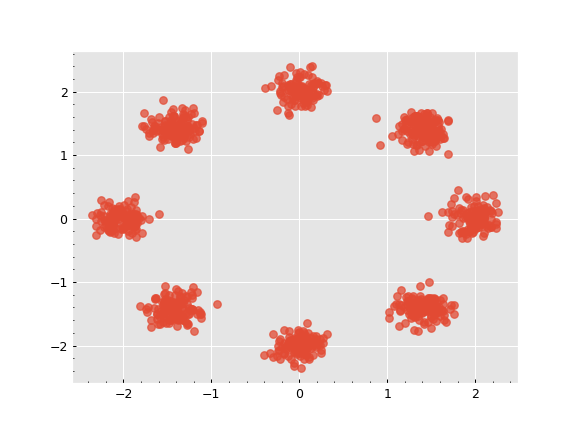

In [40]:
%matplotlib notebook
samples = distribution.get_samples(1000)
fig, ax = plt.subplots()
ax.plot(samples[:, 0], samples[:, 1], marker='o', ls='', alpha=0.75)
plt.show()

In [42]:
mu1, mu2 = distribution.mus[0], distribution.mus[1]
diff = mu1 - mu2
dist = np.sqrt(diff.T.dot(diff))

In [43]:
dist

1.530733729460359

### Load / restore model

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
kwargs = {'radius': 1.0, 'sigma': sigma, 'num_distributions': 8}
model = GaussianMixtureModel(params, 
                             config=config,
                             log_dir='../log_mog_tf/run_327/',
                             covs=covs,
                             distribution=distribution,
                             **kwargs)

Initial parameters written to ../log_mog_tf/run_327/run_info/_init_params.pkl.
Loading from previous parameters in from: ../log_mog_tf/run_327/run_info/
################################################################################
Model parameters:
x_dim: 2

num_distributions: 8

eps: 1.0

scale: 0.1

num_samples: 200

sigma: 0.02

small_pi: 2e-16

lr_init: 0.01

temp_init: 15

annealing_steps: 163

annealing_factor: 0.98

num_training_steps: 25000

tunneling_rate_steps: 1000

lr_decay_steps: 2500

lr_decay_rate: 0.96

logging_steps: 100

save_steps: 1000

arrangement: axes

radius: 1.0

annealing_rate: 0.98

temp: 1.0421572411794293

_annealing_steps_init: 500

_tunneling_rate_steps_init: 1000

log_dir: ../log_mog_tf/run_327/

info_dir: ../log_mog_tf/run_327/run_info/

figs_dir: ../log_mog_tf/run_327/figures/

trajectory_length: 2

################################################################################




In [7]:
model._restore_model()

Restoring previous model from: ../log_mog_tf/run_327/model.ckpt-33415
INFO:tensorflow:Restoring parameters from ../log_mog_tf/run_327/model.ckpt-33415
Model restored.



### Generate trajectories from restored model

In [8]:
target_samples = model.distribution.get_samples(500)

In [10]:
trajectories, losses, px = model.generate_trajectories(temp=1., 
                                                       num_samples=100, 
                                                       num_steps=250)

In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


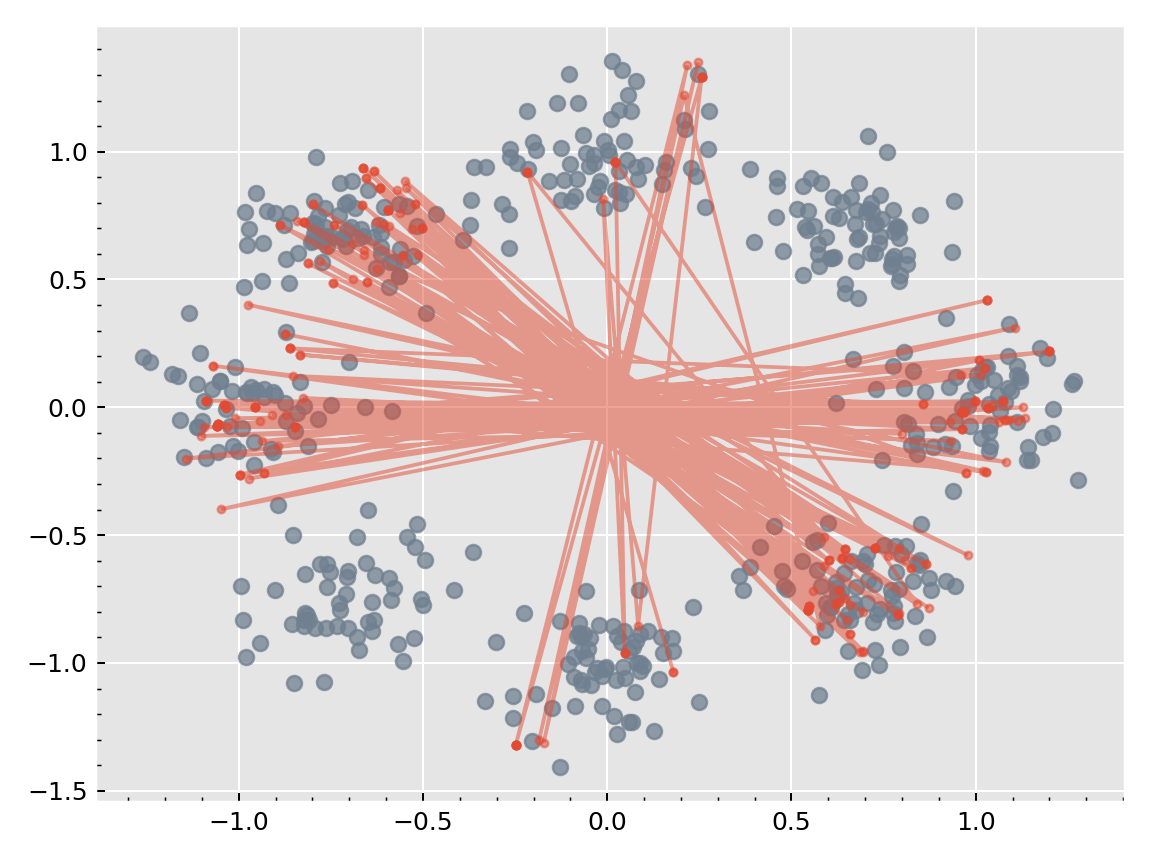

<IPython.core.display.Javascript object>


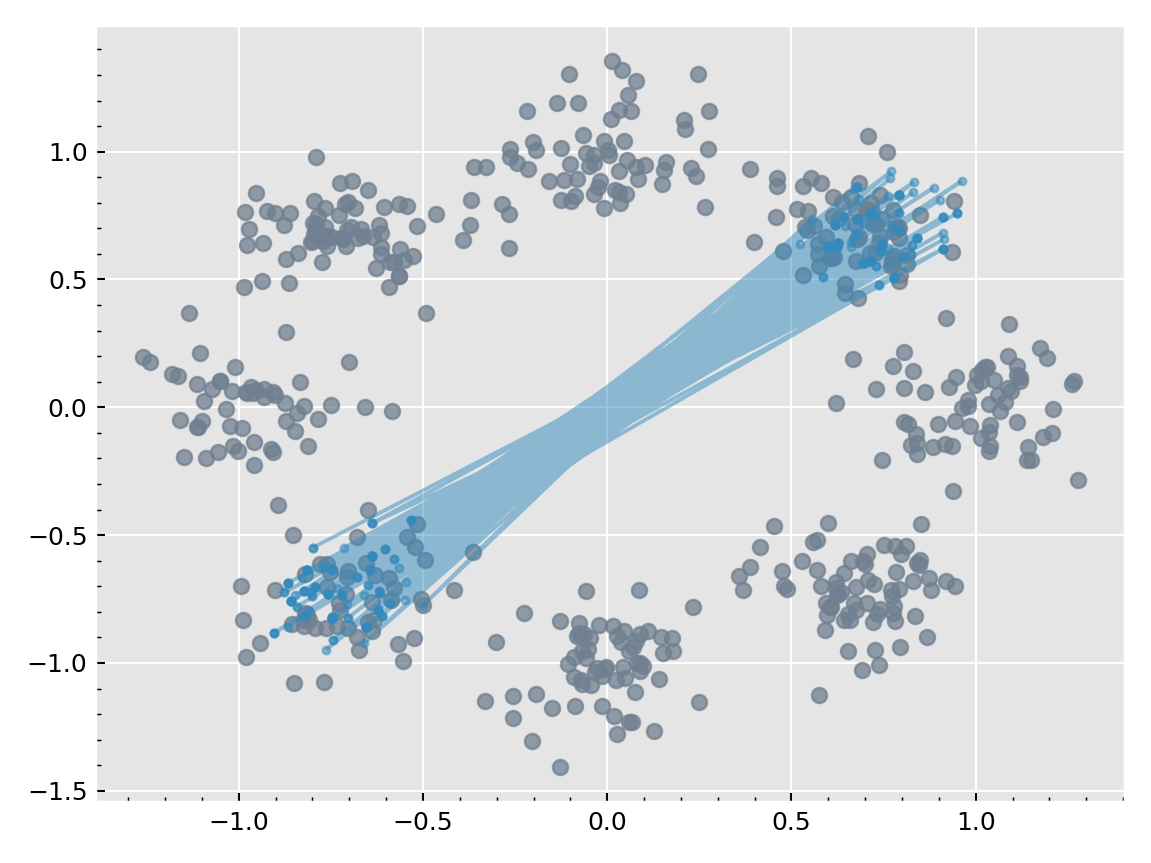

<IPython.core.display.Javascript object>


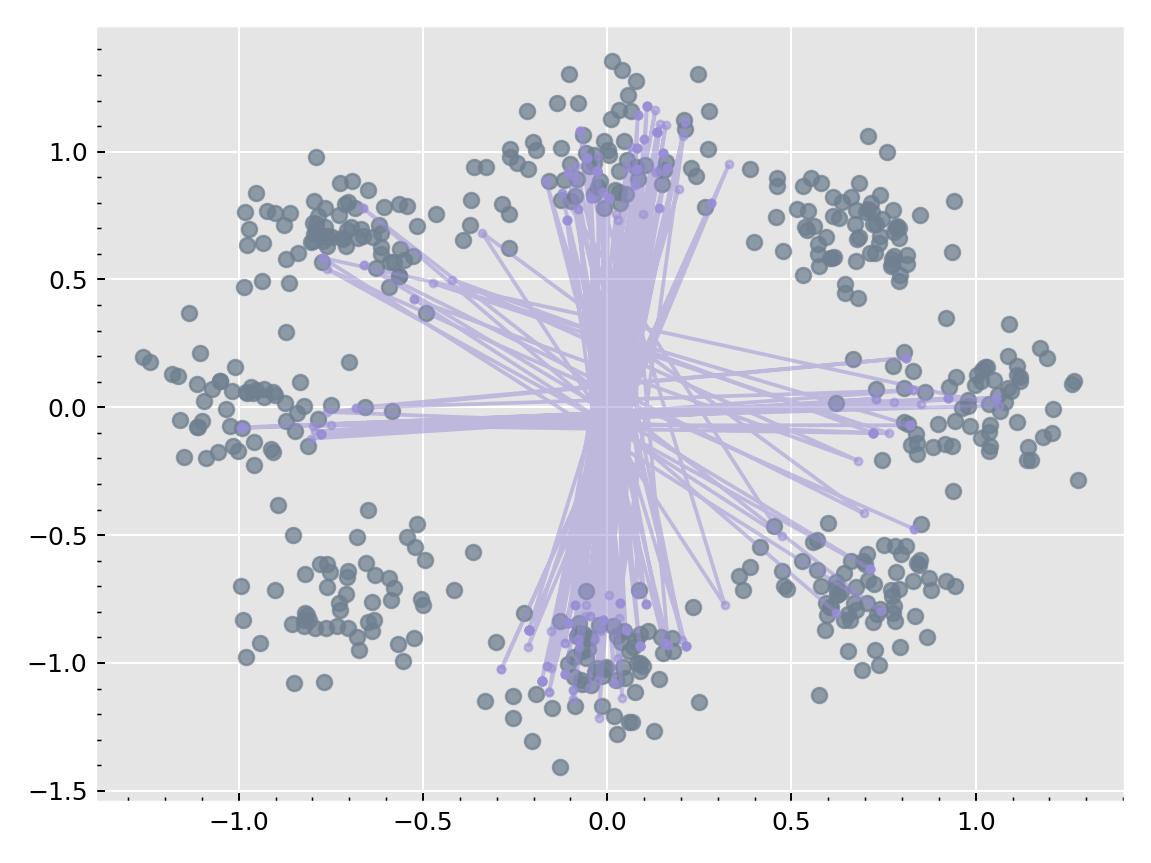

<IPython.core.display.Javascript object>


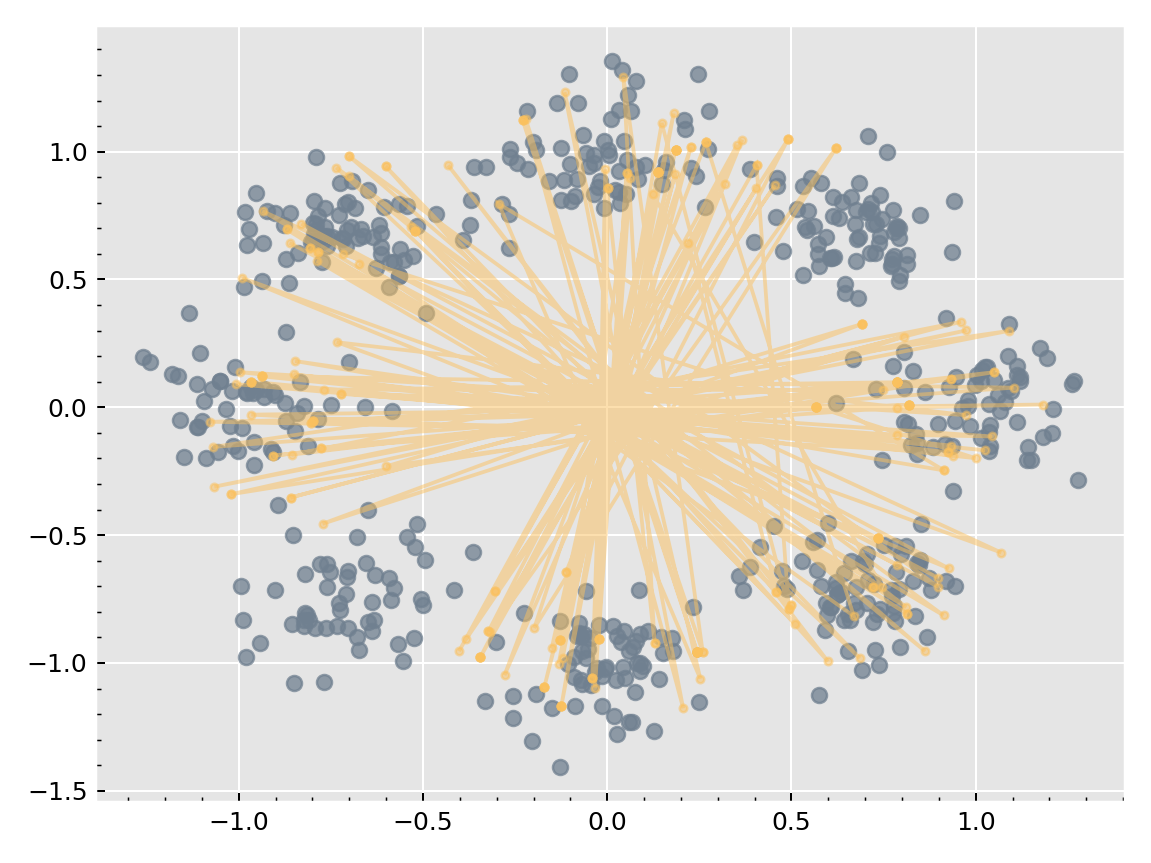

<IPython.core.display.Javascript object>


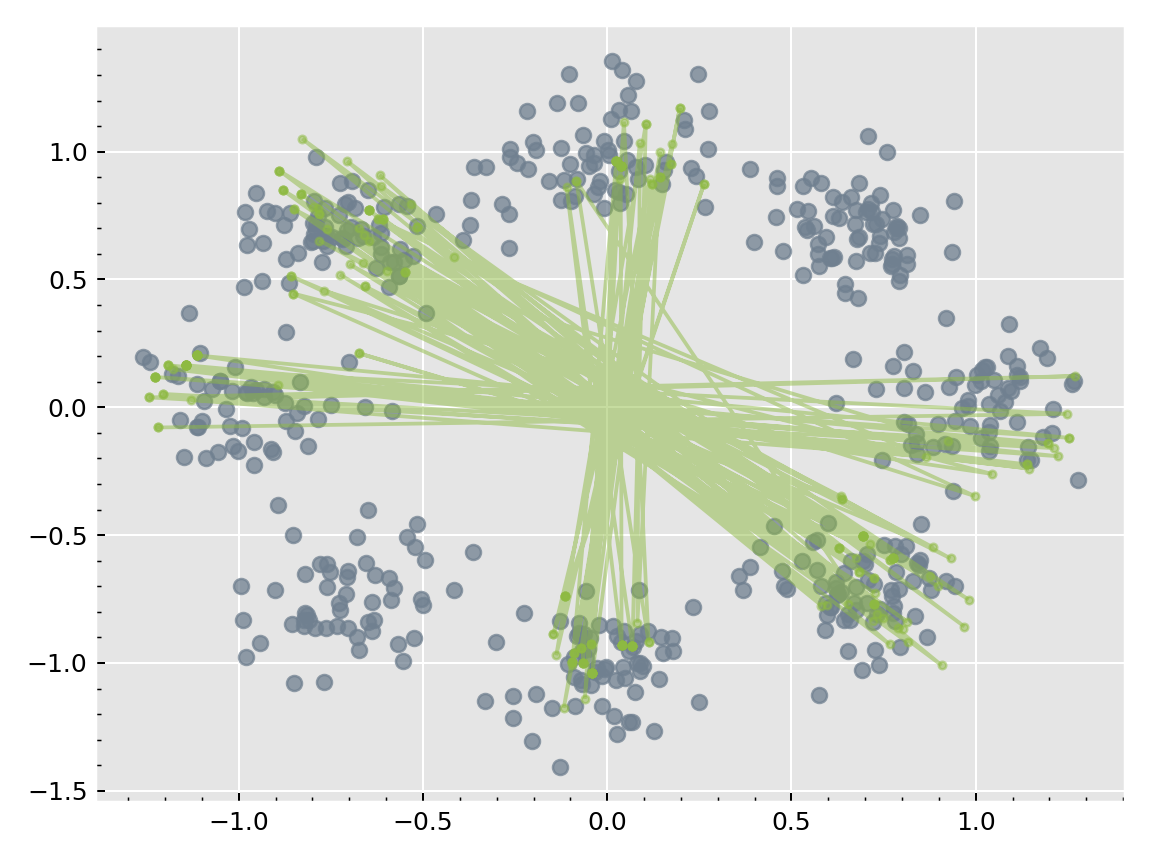

In [19]:
idxs = [rand_traj(trajectories) for _ in range(5)]
nums = np.arange(len(idxs))
labels = ['trajectory ' + str(i) for i in nums]
for num, idx in enumerate(idxs):
    fig, ax = plt.subplots()
    _ = ax.plot(target_samples[:,0], target_samples[:,1], marker='o', ls='', alpha=0.75, color='slategrey')
    #for i in range(3):
    #for num, idx in enumerate(idxs):
    _ = ax.plot(trajectories[:, idx, 0], trajectories[:, idx, 1], marker='.', ls='-', alpha=0.5, color=colors[num])#, label=labels[num], color=colors[num])
    #_ = ax.plot(trajectories[:, idxs[0], 0], trajectories[:, idxs[0], 1], marker='.', ls='-', alpha=0.5)#, label=labels[num], color=colors[num])
    #ax.legend(loc='lower left')
    fig.tight_layout()
    plt.show()
    plt.savefig(f'../log_mog_tf/run_327/figures/trajectory_{num}.pdf', dpi=400, bbox_inches='tight')

In [42]:
samples = np.transpose(trajectories, [1, 0, 2])
print(samples.shape)

(200, 500, 2)


In [43]:
trajectory = samples[0, :, :]

In [46]:
trajectory.shape

(500, 2)

<IPython.core.display.Javascript object>


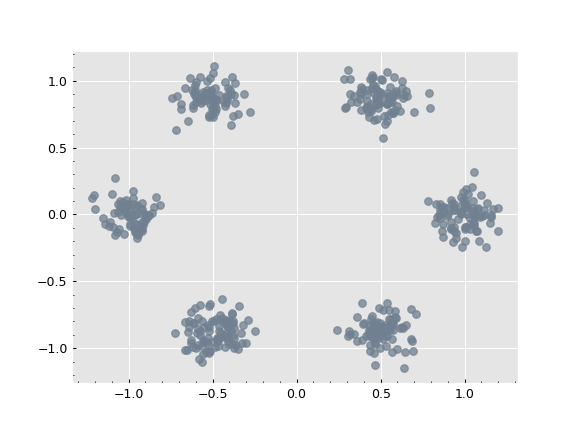

In [45]:
fig, ax = plt.subplots()
_ = ax.plot(target_samples[:,0], target_samples[:,1], marker='o', ls='', alpha=0.75, color='slategrey')
line, = ax.plot(trajectories[:, 0, 0], trajectories[:, 0, 1], marker='.', ls='-', alpha=0.5)#, color=colors[i])
ani = animation.FuncAnimation(fig, update, 250, fargs=(trajectory[:, line),
                              repeat=True, interval=10000/250, blit=False)
plt.show()

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = p3.Axes3D(fig)

N = 250
#data = np.array(list(gen(N))).T
#_data = training_sample[:, :N]
data1 = ts[:, :N]
ax.scatter(init_samples[:, 0], init_samples[:, 1], init_samples[:, 2],
           alpha=0.4, marker='o', s=10, color='slategrey')
line, = ax.plot(data1[0, 0:1], data1[1, 0:1], data1[2, 0:1], 
                alpha=0.7, color='C1', marker='o', markersize=3, ls='-', lw=1.)

ax.set_xlim(-0.5, 2.0)
ax.set_ylim(-0.5, 2.0)
ax.set_zlim(-0.8, 0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ani = animation.FuncAnimation(fig, update, N, fargs=(data1, line), 
                              repeat=False, interval=10000/N, blit=False)
plt.show()

In [ ]:
ani.save('./log_mog_tf/run91/MoG_trajectory_250t_32499train.gif', 
         writer='imagemagick')

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(training_sample.T[:10, 0], training_sample.T[:10, 1], training_sample.T[:10, 2],
           alpha=0.5, marker='o', color='C0')
plt.show()

In [ ]:
#training_samples = np.load('./log_mog_tf/run91/run_info/training_samples.npy')

#training_sample = training_samples[-1, :, 0, :].T
#print(training_sample.shape)

#ts = training_samples[-1, :, -1, :].T

#x_dim = 3
#sigma = 0.05
#means = np.array([[np.sqrt(2), 0.0, 0.0],
#                  [0.0, np.sqrt(2), 0.0],
#                  [np.sqrt(2), 0.0, 0.0]]).astype(np.float32)
#cov_mtx = np.array([[sigma, 0.0, 0.0],
#                    [0.0, sigma, 0.0],
#                    [0.0, 0.0, sigma]]).astype(np.float32)
#covs = np.array([cov_mtx, cov_mtx, cov_mtx]).astype(np.float32)
                
#small_pi = 2E-16
#big_pi = (1 - small_pi) / 2
#distribution = GMM(means, covs, [big_pi, big_pi, small_pi])
#distribution = GMM(means, covs, [0.5, 0.5])
# Get some samples from the true distribution for debugging
#init_samples = distribution.get_samples(1000)